---
title: STEM Simulation
authors: [gvarnavides]
date: 2025-06-11
---

In [1]:
import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

## Build atomic model

We start by creating a model of MoS<sub>2</sub>, whose unit cell we repeat to accomodate the size of the probe wave function (see abTEM [multislice walkthrough](https://abtem.github.io/doc/user_guide/walkthrough/multislice.html)).

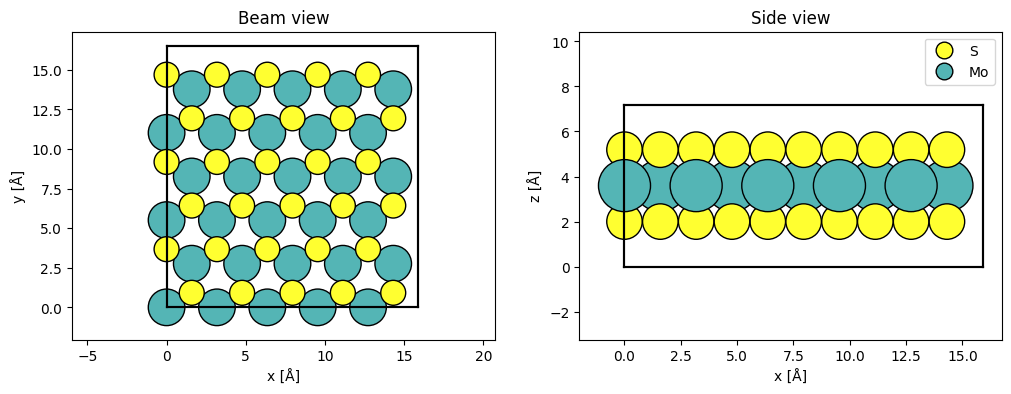

In [3]:
atoms = ase.build.mx2(vacuum=2)
atoms = abtem.orthogonalize_cell(atoms)
atoms = atoms * (5, 3, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, title="Beam view", ax=ax1)
abtem.show_atoms(atoms, legend=True, plane="xz", title="Side view", ax=ax2);

Next, we create a `Potential` with a sampling of $0.05 \ \mathrm{Å}$ and a `Probe` with an energy of $80 \ \mathrm{keV}$ and a convergence semiangle of $20 \ \mathrm{mrad}$ (and match its sampling to the potential).

In [5]:
potential = abtem.Potential(atoms, sampling=0.05).build(lazy=False)

probe = abtem.Probe(energy=80e3, semiangle_cutoff=20)
probe.grid.match(potential)

## STEM simulations

Set up detectors: We'll create 2 integrating detectors and a pixelated detector.

In [6]:
bf_detector = abtem.AnnularDetector(inner=0, outer=30)
adf_detector = abtem.AnnularDetector(inner=90, outer=200)
pixelated_detector = abtem.PixelatedDetector(max_angle=200)

all_detectors = [bf_detector, adf_detector, pixelated_detector]


We perform typical STEM simulations using a `GridScan`. The probe step size (or `sampling`) is set to the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency) of the probe contrast transfer function.

Nyquist sampling = 0.522 Å/pixel


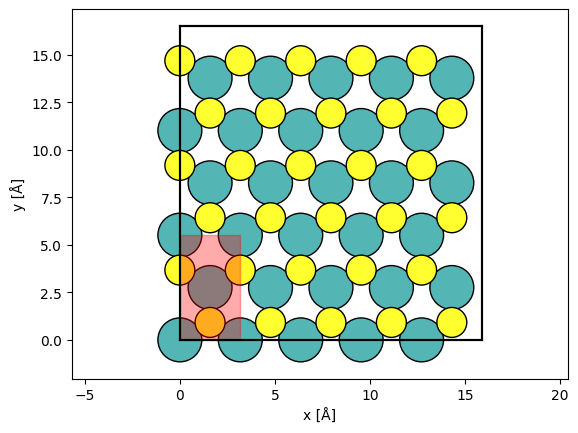

In [8]:
sampling = probe.ctf.nyquist_sampling
print(f"Nyquist sampling = {sampling:.3f} Å/pixel")

grid_scan = abtem.GridScan(
    start=[0, 0],
    end= [potential.extent[0]/5,potential.extent[1]/3],
    sampling=sampling,
)

fig,ax = plt.subplots()
abtem.show_atoms(atoms,ax=ax)
grid_scan.add_to_plot(ax);

We can collect data from all detectors at the same time

In [9]:
bf, adf, pixelated_measurement = probe.scan(potential=potential, scan=grid_scan, detectors=all_detectors,lazy=False)

## Inspect data

First, let's check the real space images from the bright field and dark field detectors

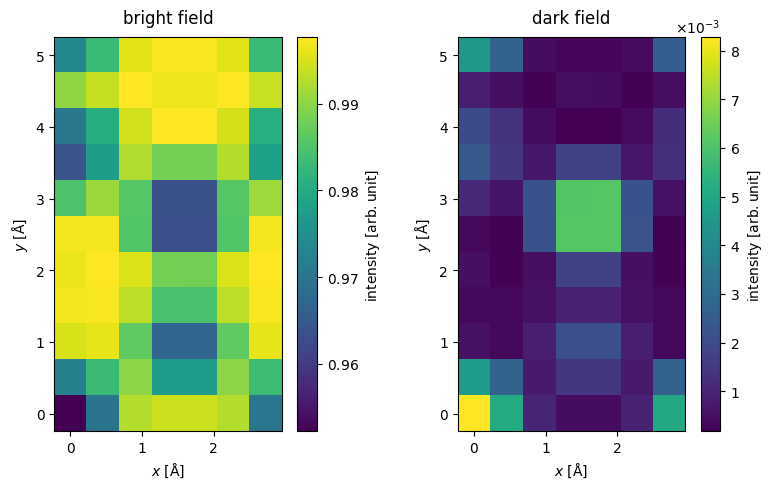

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))

bf.show(ax=ax1,cbar=True, cmap='viridis', title="bright field")
adf.show(ax=ax2,cbar=True, cmap='viridis', title="dark field")

fig.tight_layout();

We can interpolate and tile this measurement because the scanned area is periodic. Be careful of artifacts when resamplign and tiling!

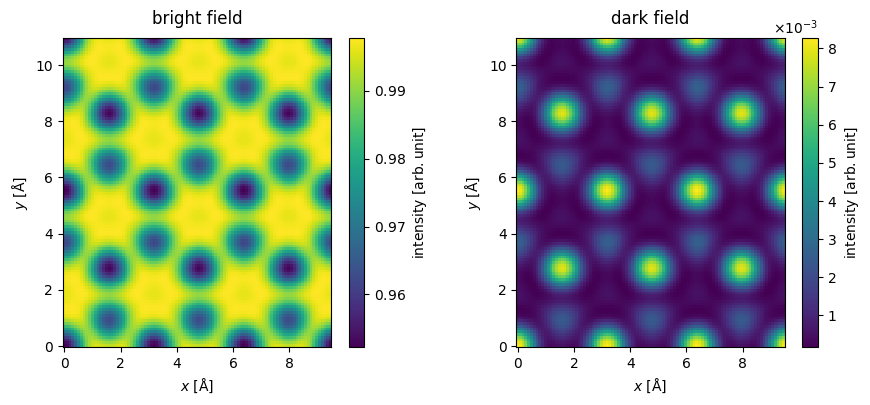

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4))

bf.interpolate(0.1).tile((3, 2)).show(ax=ax1,cbar=True, cmap='viridis', title="bright field")
adf.interpolate(0.1).tile((3, 2)).show(ax=ax2,cbar=True, cmap='viridis', title="dark field")

fig.tight_layout();

Check diffraction patterns:

In [15]:
dp = pixelated_measurement[1,1]

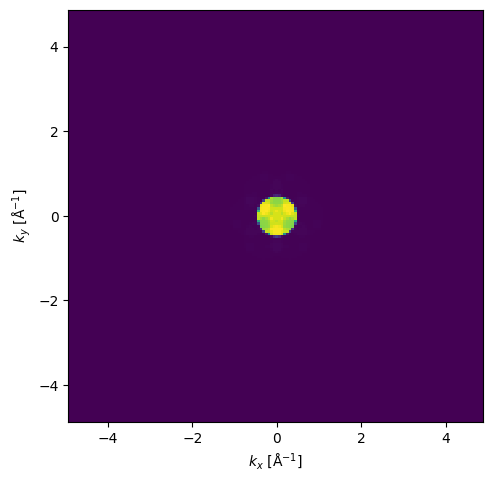

In [19]:
pixelated_measurement.show()

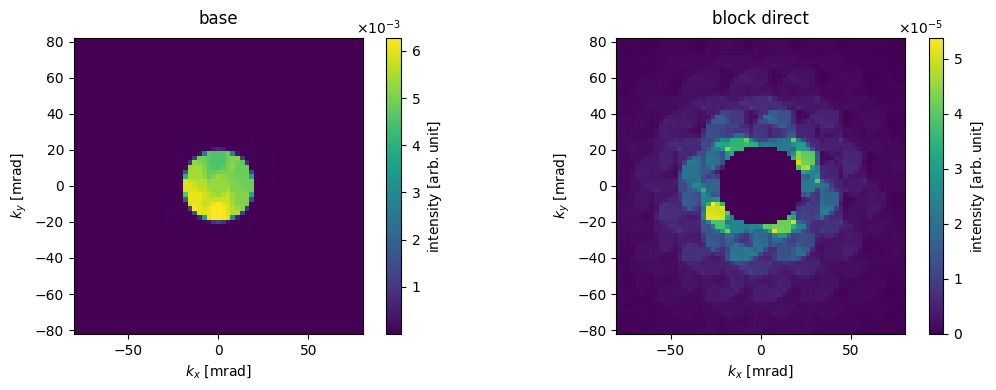

In [23]:
fig, axs = plt.subplots(1,2,figsize=(11, 4))

pixelated_measurement[1,1].crop(max_angle=80).show(cmap='viridis',ax=axs[0],cbar=True, title="base",units='mrad')
pixelated_measurement[1,1].crop(max_angle=80).block_direct().show(cmap='viridis',ax=axs[1],cbar=True, title="block direct",units='mrad')

fig.tight_layout();

We can calculate virtual images from our 4D-STEM scan. With the same collection angles, these should match our images above.

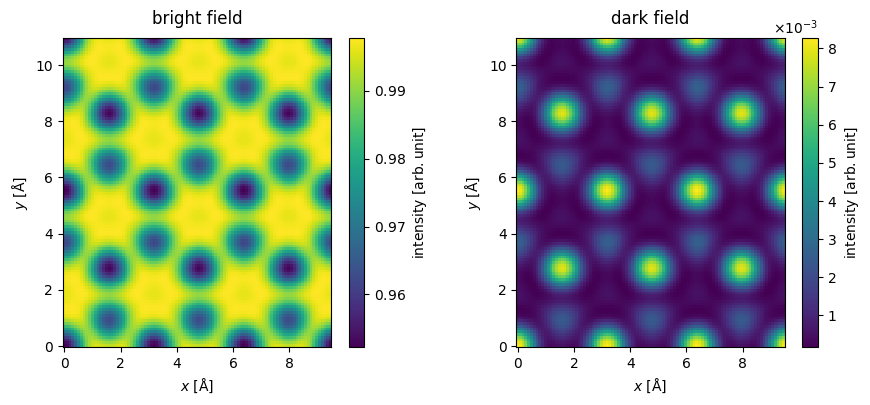

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4))

pixelated_measurement.integrate_radial(bf_detector.inner,bf_detector.outer).interpolate(0.1).tile((3, 2)).show(ax=ax1,cbar=True, cmap='viridis', title="bright field")
pixelated_measurement.integrate_radial(adf_detector.inner,adf_detector.outer).interpolate(0.1).tile((3, 2)).show(ax=ax2,cbar=True, cmap='viridis', title="dark field")

fig.tight_layout();

We can also calulate the center of mass for a DPC phase contrast reconstruction:

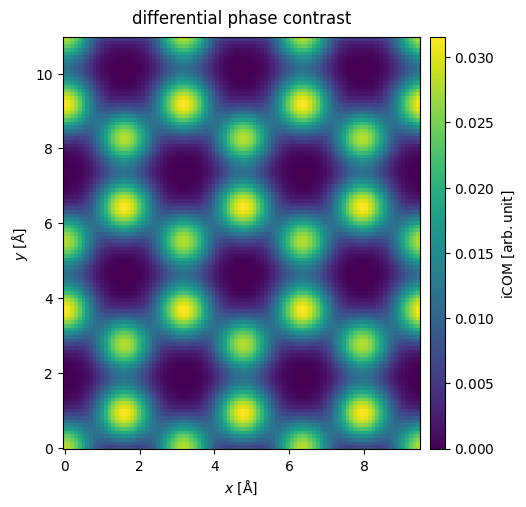

In [32]:
dpc_phase = pixelated_measurement.center_of_mass().integrate_gradient()
dpc_phase.interpolate(0.1).tile((3, 2)).show(cbar=True,cmap='viridis',title='differential phase contrast');